## Install master branches of theano and lasagne
[Here are the instructions](http://lasagne.readthedocs.io/en/latest/user/installation.html#bleeding-edge-version)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('talk')

import pymc3 as pm
import theano.tensor as tt
import theano

from scipy.stats import mode, chisquare
from sklearn.metrics import confusion_matrix, accuracy_score
import lasagne
import os


In [2]:
#(3.2, u'1.0.1', '0.2.dev1')
pm.__version__, theano.__version__, lasagne.__version__


('3.2', '0.9.0.dev-unknown-git', '0.2.dev1')

### notMNIST images courtesy Y. Bulatov
[notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html)

In [4]:
from pathlib import Path

filename='notMNIST_small.tar.gz'
basedir = 'data/notMNIST/'
localfile = os.path.join(basedir, filename)
if not Path(basedir).exists():
    Path(basedir).mkdir(parents=True, exist_ok=True)

## Preprocess notMNIST
Adapted from code by Y. Bulatov 
Source: http://yaroslavvb.com/upload/notMNIST/matlab_convert.py

C:\Anaconda3\envs\stpy35\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


data/notMNIST/notMNIST_small/
Found 18726 files
exception cannot identify image file 'data/notMNIST/notMNIST_small/A\\RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png'
exception cannot identify image file 'data/notMNIST/notMNIST_small/F\\Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png'


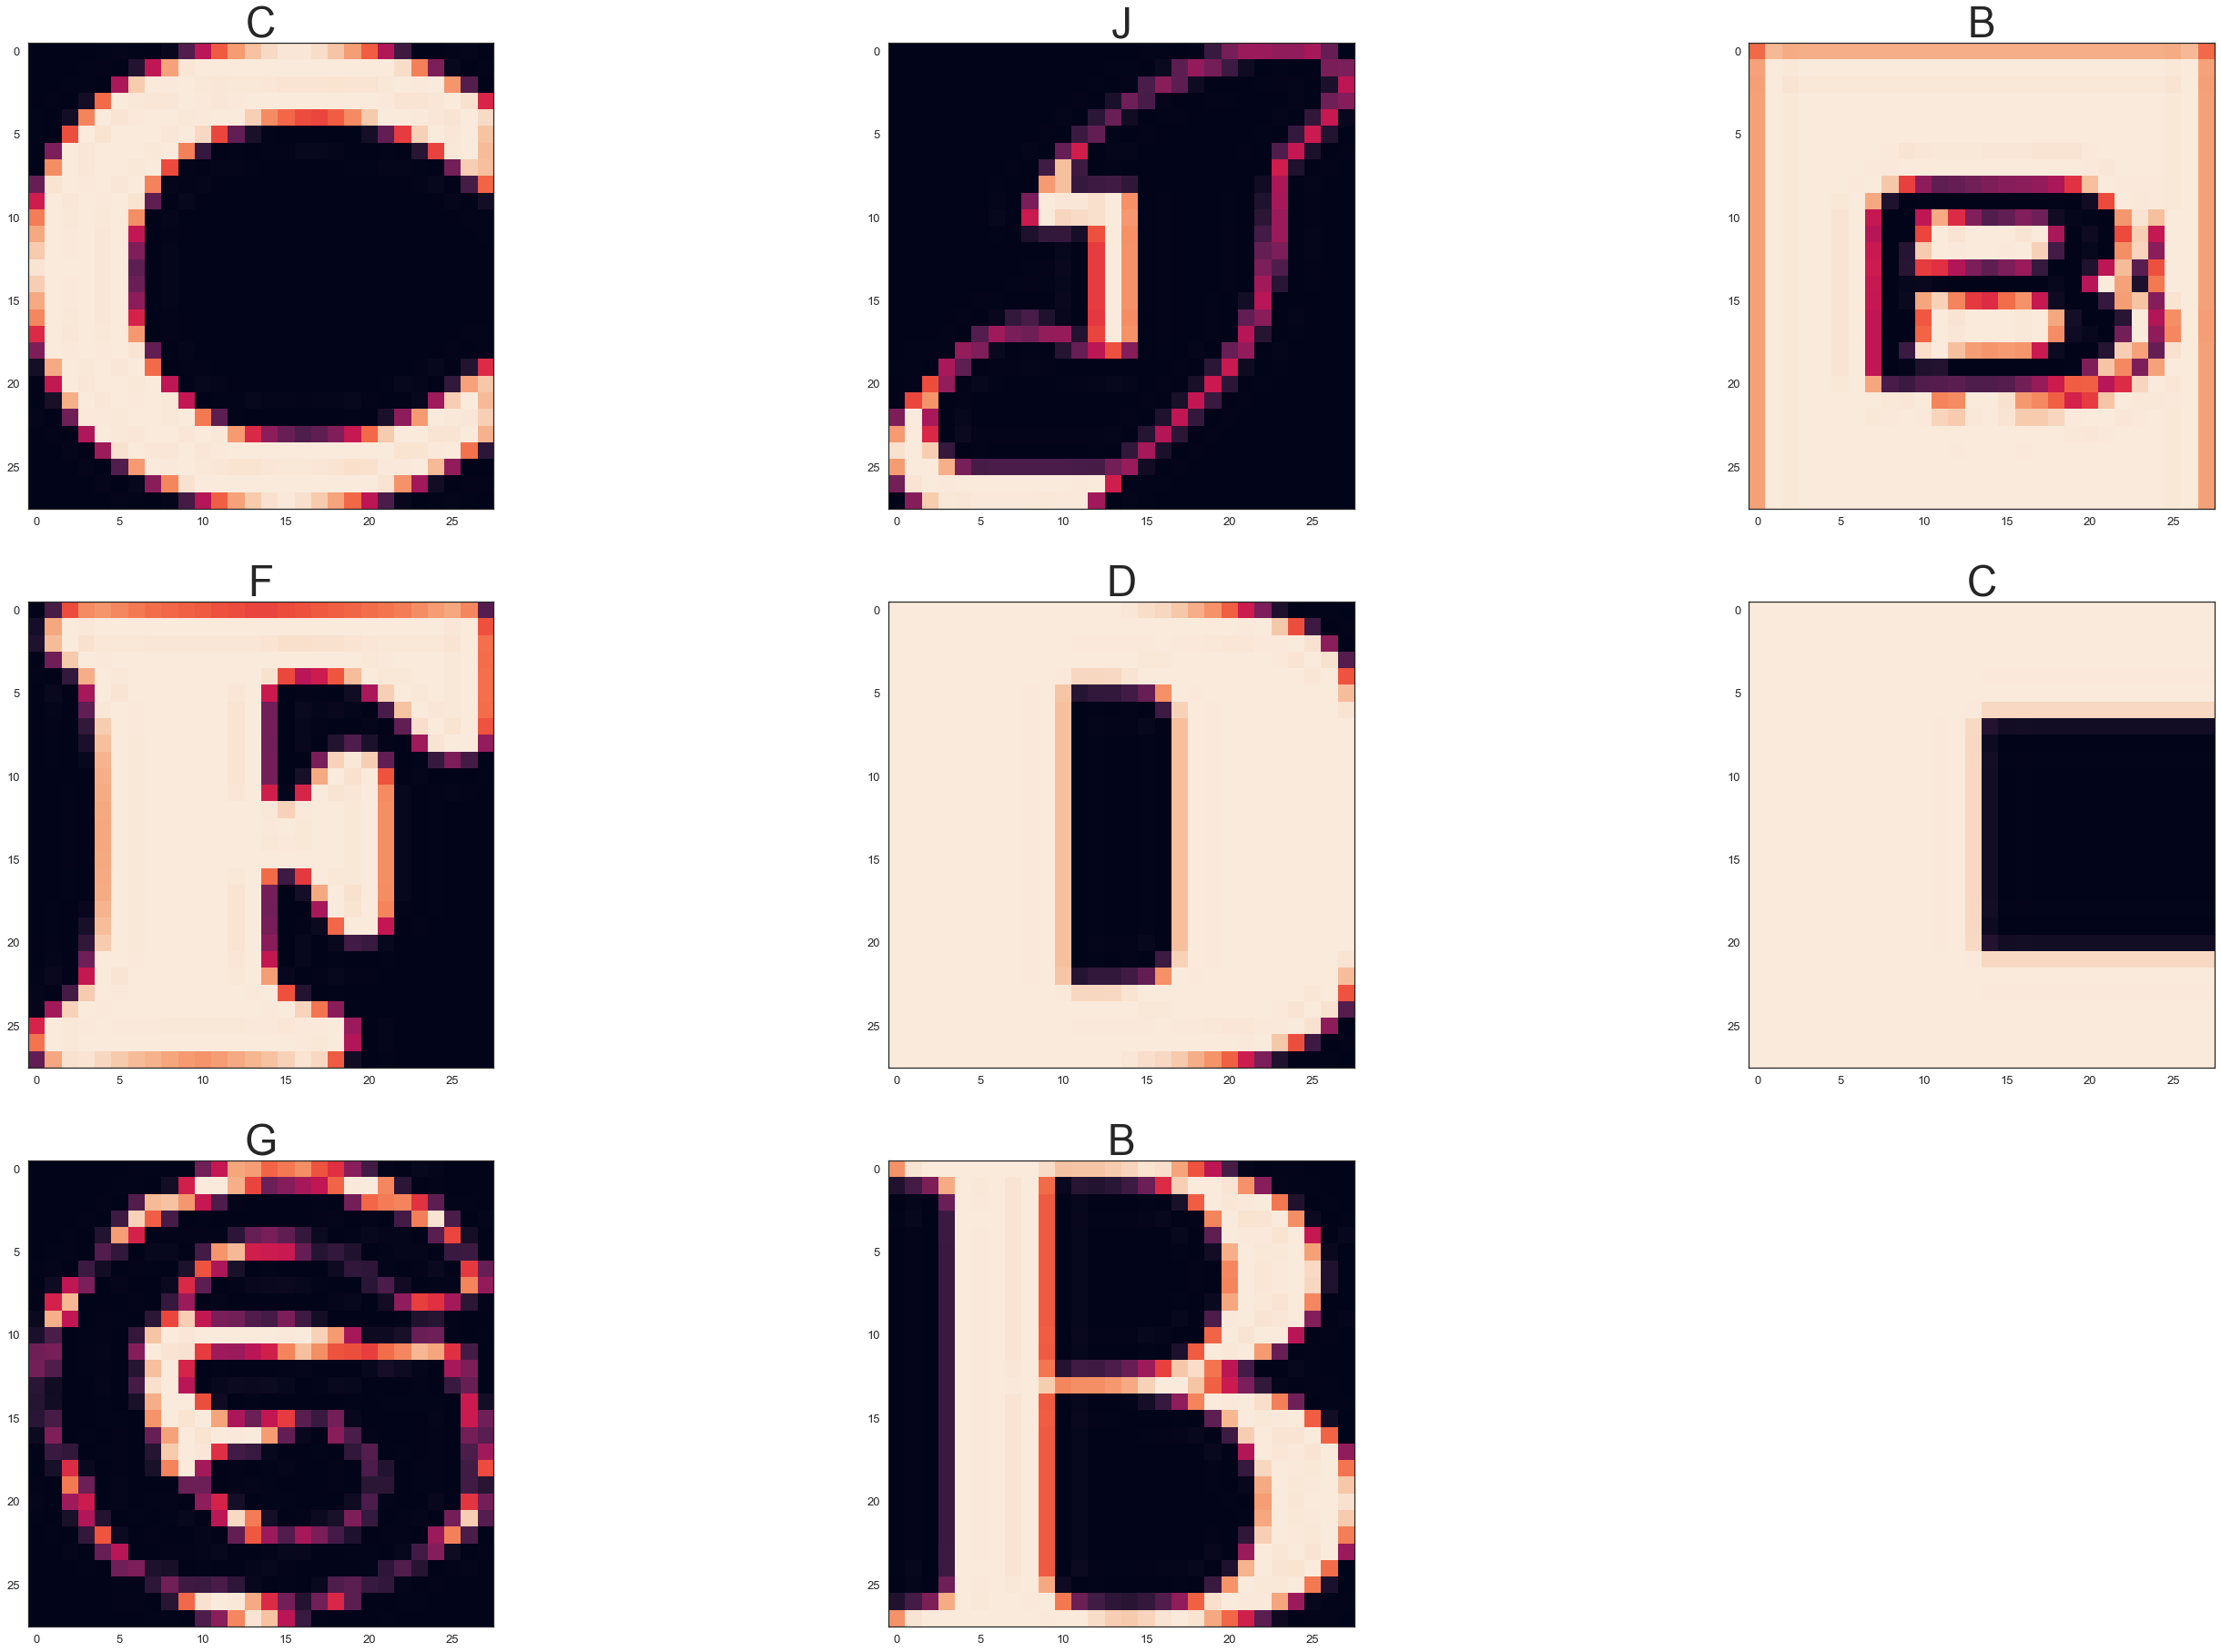

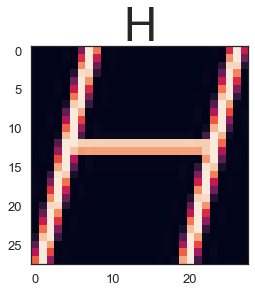

In [5]:
import sys, os
from scipy.io import savemat
import numpy as np, glob, sys, os
import PIL.Image as Image
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split
import tarfile

def load_dataset():
    #support both python 2 and 3
    if sys.version_info[0] == 2:
        from urllib import urlretrieve
    else:
        from urllib.request import urlretrieve

    basedir = 'data/notMNIST/'
    if not os.path.exists(basedir):
        os.makedirs(basedir)
        
    def download(filename, source='http://yaroslavvb.com/upload/notMNIST/'):
        localfile = os.path.join(basedir, filename)
        if not os.path.exists(localfile):
            print ("Downloading %s" % filename)
            urlretrieve(source + filename, localfile)

    download(filename)

    def extract():
        tar = tarfile.open(localfile)
        tar.extractall(path=basedir)
        tar.close()
        
    extract()
    
    def reshape_X(X_pre):
        X_post = np.zeros((X_pre.shape[0], 1, 28, 28))
        for i in range(X_pre.shape[0]):
            X_post[i, 0, :, :] = X_pre[i, :, :]
        return X_post

    mapping = {}

    def generate_dataset(folder):
        print(folder)
        max_count = 0
        for (root, dirs, files) in os.walk(folder):
            for f in files:
                if f.endswith('.png'):
                    max_count+=1

        print('Found %s files'%(max_count))
        data = np.zeros((28,28,max_count))
        labels = np.zeros((max_count,))
        count = 0
        for (root, dirs, files) in os.walk(folder):
            for f in files:
                if f.endswith('.png'):
                    try:
                        #print("opening {}, {}, {}".format(root, f, os.path.join(root, f)))
                        img = Image.open(os.path.join(root, f));
                        #print("{}, {}".format(f, dirs))
                        data[:,:,count]=np.asarray(img)
                        surround_folder = os.path.split(root)[-1]
                        assert len(surround_folder)==1
                        ordinal = ord(surround_folder)-ord('A')
                        labels[count]=ordinal
                        mapping[ordinal] = surround_folder
                        count+=1
                    except Exception as e:
                        print("exception {}".format(e))
                        pass

        # Plot NUM samples
        fig = plt.figure()
        COLS, NUM = 3, 8
        np.random.seed(NUM)
        for i in range(NUM):
            ax = fig.add_subplot(COLS, np.ceil(NUM/float(COLS)), i + 1)
            x = np.random.randint(max_count)
            a0, c0 = data[:, :, x], labels[x]
            plt.imshow(a0)
            plt.title(mapping[c0], fontsize=46)
        fig.set_size_inches(np.array(fig.get_size_inches())*NUM)
        #print("data: {}, {}".format(data[:, :, :count].shape, labels[:count].shape))
        ndata = np.zeros((max_count, 28, 28))
        for i in range(max_count):
            ndata[i, :, :] = data[:, :, i]

        fig = plt.figure()
        x = np.random.randint(max_count)
        #print("ndata: {},{},{}".format(x, ndata[x].shape, ndata[x, :, :]))
        a0, c0 = ndata[x, :, :], labels[x]
        plt.imshow(a0)
        plt.title(mapping[c0], fontsize=46)
    
        X_train, X_test, y_train, y_test = train_test_split(ndata[:count], labels[:count], test_size=0.1)
        X_train, X_test = reshape_X(X_train), reshape_X(X_test)
        return X_train, X_test, y_train, y_test
    
    return generate_dataset('data/notMNIST/notMNIST_small/')

X_train, X_test, y_train, y_test = load_dataset()


In [43]:
#theano shared vars
minibatch_x = pm.Minibatch(X_train, batch_size=500, dtype='float64')
minibatch_y = pm.Minibatch(y_train, batch_size=500, dtype='float64')


In [44]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, minibatch_x.eval().shape, minibatch_y

((16851, 1, 28, 28),
 (1873, 1, 28, 28),
 (16851,),
 (1873,),
 (500, 1, 28, 28),
 Minibatch)

## Priors

In [45]:
class GaussianWeights(object):
    def __init__(self):
        self.count = 0
    def __call__(self, shape):
        self.count += 1
        return pm.Normal('w%d' % self.count, 
                         mu=0, 
                         sd=.1,
                         testval=np.random.normal(size=shape).astype(np.float64),
                         shape=shape)
    

## Model specification

In [46]:
def build_ann(init, in_var, out_var):
    with pm.Model() as cnn:
        network = lasagne.layers.InputLayer(shape=(None, 1, 28, 28), input_var=in_var)
        network = lasagne.layers.DenseLayer(network, num_units=25, nonlinearity=lasagne.nonlinearities.tanh,
                                          b=init,
                                          W=init)
        network = lasagne.layers.DenseLayer(network, num_units=25, nonlinearity=lasagne.nonlinearities.tanh,
                                          b=init,
                                          W=init)
        #Final layer of 10 units, softmax across 10 labels
        network = lasagne.layers.DenseLayer(network, num_units=10, nonlinearity=lasagne.nonlinearities.softmax,
                                         b=init,
                                         W=init)
        prediction = lasagne.layers.get_output(network)
        #categorical distribution
        out = pm.Categorical('out', p=prediction, observed=out_var, total_size=y_train.shape[0])
    return cnn


In [ ]:
import theano.sandbox.cuda as cuda
x = cuda.CudaNdarrayType(minibatch_x.minibatch)
y = cuda.CudaNdarrayVariable(minibatch_y)

x.eval().shape


In [47]:
cnn = build_ann(GaussianWeights(), minibatch_x, minibatch_y)

## Now put them together

In [53]:
with cnn:
    approx = pm.fit(50, method='advi', 
                   # more_replacements={in_var:minibatch_x, out_var:minibatch_y}
                   )
    trace = approx.sample(draws=620)
    ppc = pm.sample_ppc(trace, samples=100)
    
    #Predict on test data
    input_var.set_value(X_test)
    target_var.set_value(y_test)
    y_pred = mode(ppc['out'], axis=0).mode[0, :]


Average Loss = 1.5904e+06: 100%|███████████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.58it/s]
Finished [100%]: Average Loss = 1.5898e+06
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 16.74it/s]


In [54]:
y_pred.shape, y_test.shape

((500,), (1873,))

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred))

In [ ]:
print("Accuracy on test: {}".format(accuracy_score(y_test, y_pred)*100))

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape,

In [ ]:
from six.moves import zip
class GaussWeightWithHR(object):
    def __init__(self):
        self.count = 0
    def __call__(self, shape):
        self.count += 1
        regularization = pm.HalfNormal('reg_hyper%d' % self.count, sd=1)
        return pm.Normal('w%d'%self.count, 
                         mu=0, 
                         sd=regularization, 
                         testval=np.random.normal(size=shape),
                         shape=shape)
minibatches = zip(
    create_minibatch(X_train, 500),
    create_minibatch(y_train, 500)
)


In [ ]:
def run_fit_sample(likelihood, advi_iters=50000):
    #Train
    input_var.set_value(X_train[:500, ...])
    target_var.set_value(y_train[:500, ...])
    #v_params = pm.fit(n=20)

    trace = pm.sample()
    
    #Predict on test data
    input_var.set_value(X_test)
    target_var.set_value(y_test)
    
    ppc = pm.sample_ppc(trace, samples=100)
    y_pred = mode(ppc['out'], axis=0).mode[0, :]
    
    return v_params, trace, ppc, y_pred

In [ ]:
with pm.Model() as hnn:
    likelihood = build_ann(GaussWeightWithHR())
    v_params, trace, ppc, y_pred = run_fit_sample(likelihood)

In [ ]:
plt.plot(v_params.elbo_vals)
sns.despine()

In [ ]:
print("Accuracy on test: {}".format(accuracy_score(y_test, y_pred)*100))

In [ ]:
pm.traceplot(trace, varnames=['reg_hyper1', 'reg_hyper2', 'reg_hyper3', 'w2'])

In [ ]:
trace.varnames

## Now a Convolutional Net
All it requires is that we change the build_ann method to include convolutional layers

In [ ]:
def build_ann_conv(init):
    network = lasagne.layers.InputLayer(shape=(None, 1, 28, 28), input_var=input_var)
    network = lasagne.layers.Conv2DLayer(network, 
                                      num_filters=32, 
                                      filter_size=(5,5),
                                      nonlinearity=lasagne.nonlinearities.tanh,
                                      W=init
                                     )
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2,2))
    network = lasagne.layers.Conv2DLayer(network,
                                        num_filters=32,
                                        filter_size=(5,5),
                                        nonlinearity=lasagne.nonlinearities.tanh,
                                        W=init)
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2,2))
    network = lasagne.layers.DenseLayer(network, 
                                        num_units=256, 
                                        nonlinearity=lasagne.nonlinearities.tanh,
                                        b=init,
                                        W=init
                                       )
    network = lasagne.layers.DenseLayer(network,
                                       num_units=10,
                                       nonlinearity=lasagne.nonlinearities.softmax,
                                       b=init,
                                       W=init)
    prediction = lasagne.layers.get_output(network)
    
    return pm.Categorical('out', prediction, observed=target_var)

In [ ]:
with pm.Model() as cnn:
    likelihood = build_ann_conv(GaussWeightWithHR())
    v_params, trace, ppc, y_pred = run_fit_sample(likelihood)

In [ ]:
print("Accuracy on test: {}".format(accuracy_score(y_test, y_pred)*100))

### Unpredictability on categorical distribution measured using Chi-squared statistic
We don't simply use the ppc standard deviation

In [ ]:
miss_class = np.where(y_test != y_pred)[0]
corr_class = np.where(y_test == y_pred)[0]
preds = pd.DataFrame(ppc['out']).T
chis = preds.apply(lambda x: chisquare(x).statistic, axis='columns')

In [ ]:
sns.distplot(chis.loc[miss_class].dropna(), label='Error')
sns.distplot(chis.loc[corr_class].dropna(), label='Correct')
plt.legend()
sns.despine()
plt.xlabel('Chi-Square Statistic')